# Pipelines
* Recent: less than 30 days
* Old: 30 days
* Stale: 90 days

In [39]:
# include common code and config
# selected_pi = 15
%run PIQM_Bootstrap.ipynb

{'pi': 'PI15', 'id': 15, 'start': '2022-06-15T00:00:00Z', 'started': '2022-06-15', 'finish': '2022-09-13T23:59:59Z'}


In [40]:
# MVP related projects from:
# https://gitlab.com/ska-telescope/ska-skampi/-/blob/master/charts/ska-mid/Chart.yaml
# https://gitlab.com/ska-telescope/ska-skampi/-/blob/master/charts/ska-low/Chart.yaml
project_ids = [ 11448712, # ska-skampi
                # 9027158,  # ska-tango-images
                23023505, # ska-tmc-centralnode
                21141217, # sdp/ska-sdp-integration
                32606296, # ska-tango-taranta-group/ska-tango-taranta-pipeline
                #32606403, # ska-tango-taranta-group/ska-tango-taranta-auth-pipeline
                #32606458, # ska-tango-taranta-group/ska-tango-taranta-dashboard-pipeline
                #17415960, # ska-ser-skuid
                15858077, # ska-dish-lmc
                10593884, # ska-sim-dishmaster
                #23023437, # ska-tmc-subarraynode
                10749136, # ska-tmc
                #21173098, # ska-ser-skallop, ska-log-consumer
                12488466, # https://gitlab.com/ska-telescope/ska-mid-cbf-mcs - gives ska-mid-cbf
                15856638, # https://gitlab.com/ska-telescope/ska-low-cbf
                25588162, # https://gitlab.com/ska-telescope/ska-csp-lmc-low
                25578388, # https://gitlab.com/ska-telescope/ska-csp-lmc-mid
                #19426925, # https://gitlab.com/ska-telescope/ska-low-cbf-proc
              ]



In [41]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "projects" and r._field == "pipeline_last_run_finished")
        |> drop(columns:["_measurement", "_field", "_time", "_start", "_stop"])
        |> group()""".format(current_pi))
# .agg(['count', 'size', 'nunique'])
df_pipeline_status = df_pipelines[["pipeline_last_run_status", "_value"]].groupby(["pipeline_last_run_status"]).agg(['count', 'size', 'nunique']).reset_index()
df_pipeline_status['pipeline_last_run_status'] = df_pipeline_status['pipeline_last_run_status'].str.title()
df_pipeline_status['count'] = df_pipeline_status['_value']['count']
# print(df_pipeline_status)
old_threshold = 30 * 24 * 60 * 60 # 30 days
stale_threshold = 90 * 24 * 60 * 60 # 90 days
df_pipelines['age'] = current_timestamp - df_pipelines['_value']
df_pipelines["stale_pipeline"] = pandas.cut(x=df_pipelines['age'],
                                            bins=[0, 1, old_threshold, stale_threshold, float('Inf')],
                                            labels=['Never', 'Recent', 'Old', 'Stale'], right=False)

df_pipelines.loc[df_pipelines['_value'] < 1,'stale_pipeline'] = 'Never'
df_pipelines['how_many'] = 1
df_pipelines['total'] = 'Total'
df_pipelines

result  table        _value got_coverage got_linting got_rtd got_tests  \
0    _result      0  1.661228e+09            0           0       0         0   
1    _result      0  1.572472e+09            0           0       0         0   
2    _result      0  1.661109e+09            0           0       0         0   
3    _result      0  1.661228e+09            0           0       0         0   
4    _result      0  1.571892e+09            0           0       0         0   
..       ...    ...           ...          ...         ...     ...       ...   
277  _result      0  1.658866e+09            1           1       1         1   
278  _result      0  1.660782e+09            1           1       1         1   
279  _result      0  1.661246e+09            1           1       1         1   
280  _result      0  1.660138e+09            1           1       1         1   
281  _result      0  1.661118e+09            1           1       1         1   

           id       license pipeline_last_run_status  \
0    12828461    apache-2.0                  success   
1    12962462  bsd-3-clause                  success   
2    13372840  bsd-3-clause                  success   
3    13540781  bsd-3-clause                  success   
4    14019587       unknown                   failed   
..        ...           ...                      ...   
277  37167217  bsd-3-clause                  success   
278  37391632         other                  success   
279  37582642  bsd-3-clause                  success   
280   9027158         other                   failed   
281   9673989         other                  success   

                                              project           age  \
0                 ska-telescope/sdp/ska-sdp-par-model  3.554919e+04   
1                    ska-telescope/pst/ska-pst-docker  8.879122e+07   
2               ska-telescope/ska-cicd-cpp-build-base  1.550363e+05   
3            ska-telescope/templates/ska-cpp-template  3.619897e+04   
4               ska-telescope/pst/ska-pst-dspsr-build  8.937144e+07   
..                                                ...           ...   
277  ska-telescope/sdp/ska-sdp-data-product-dashboard  2.397364e+06   
278         ska-telescope/low-cbf/ska-low-cbf-sw-cnic  4.820934e+05   
279        ska-telescope/sdp/ska-sdp-data-product-api  1.799865e+04   
280                    ska-telescope/ska-tango-images  1.125774e+06   
281                  ska-telescope/ska-tango-examples  1.457555e+05   

    stale_pipeline  how_many  total  
0           Recent         1  Total  
1            Stale         1  Total  
2           Recent         1  Total  
3           Recent         1  Total  
4            Stale         1  Total  
..             ...       ...    ...  
277         Recent         1  Total  
278         Recent         1  Total  
279         Recent         1  Total  
280         Recent         1  Total  
281         Recent         1  Total  

[282 rows x 15 columns]

In [42]:
df_state_age = df_pipelines[["pipeline_last_run_status", "stale_pipeline", "id"]]\
    .groupby(["pipeline_last_run_status", "stale_pipeline"])\
    .agg(['count', 'size', 'nunique']).reset_index()
df_state_age['count'] = df_state_age['id']['count']
# .agg(['count', 'size', 'nunique'])
# df_state_age = df_state_age[df_state_age["id"] != 0]

df_state_age = df_state_age[["pipeline_last_run_status", "stale_pipeline", "count"]]\
    .rename(columns={"pipeline_last_run_status": "Last run status", "stale_pipeline": "Stale"})\
    .sort_values(["count"], ascending=False)

df_state_age.style.hide_index()\
    .set_properties(subset=['Last run status', 'Stale'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('SKA Pipeline Last Run')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])


# df_state_age


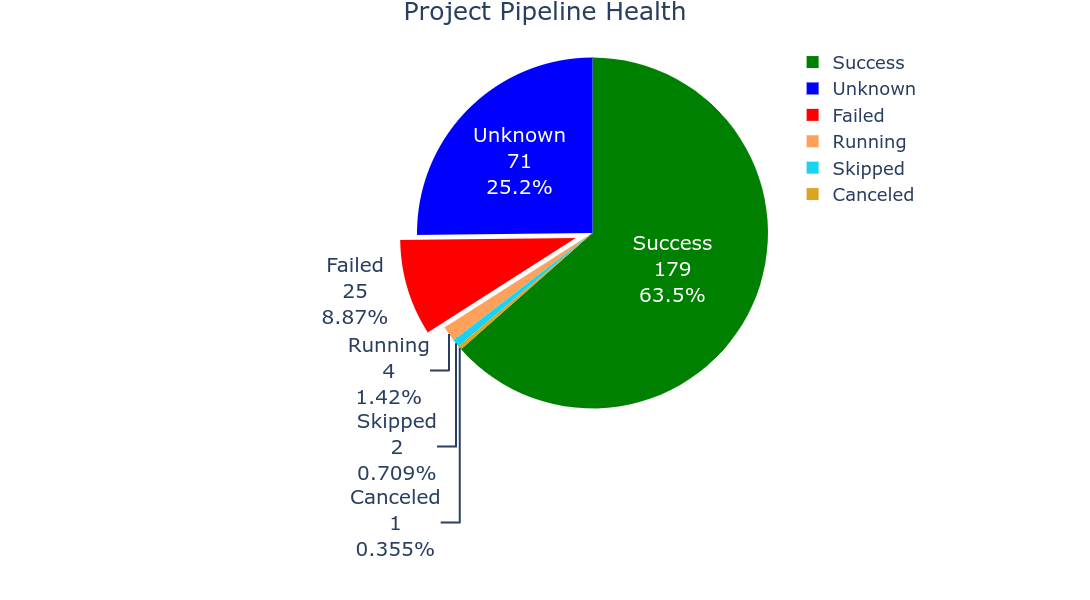

In [43]:
fig = px.pie(df_pipeline_status, values='count',
             names='pipeline_last_run_status',
             title='Project Pipeline Health',
             color='pipeline_last_run_status', 
#              color_discrete_sequence=px.colors.sequential.RdBu)
             color_discrete_map={
                "Success": "green",
                "Unknown": "blue",
                "Failed": "red",
                "Canceled": "goldenrod"})
fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', 
                  font=dict(size=18,), 
                  margin = dict(t=40, l=0, r=0, b=0),
                 legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.80
                    ))
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent+label', textfont_size=20, pull=[0, 0.1, 0, 0])
fig.show()


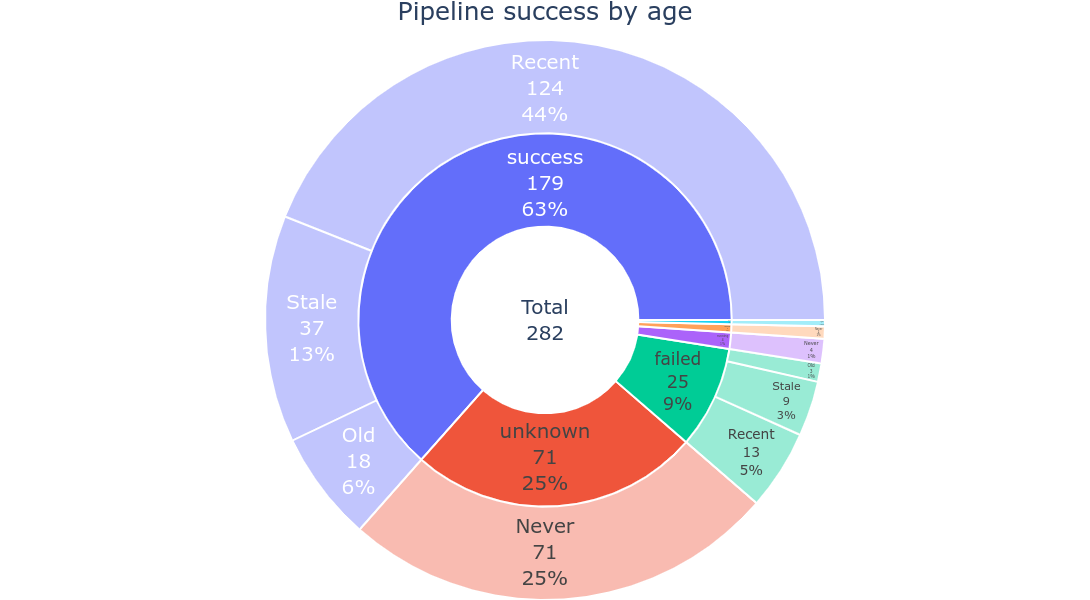

In [44]:
import plotly.express as px
fig = px.sunburst(df_pipelines, 
                  title="Pipeline success by age",
                  height=600,
                  path=['total', 'pipeline_last_run_status', 'stale_pipeline'], 
                  values='how_many', 
                  branchvalues="total",
#                  color_discrete_map={'Total': 'white'}
                 )


fig.update_traces(textinfo='label+value+percent entry', 
                  textfont_size=20, 
                  insidetextorientation='horizontal',
                  leaf={'opacity': 0.4},
                  marker={'line': {'width': [2 for i in range(len(df_pipelines))], 'color': '#fff'}},
                 )

fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', font=dict(size=18,),
                  margin = dict(t=40, l=0, r=0, b=0),)

fig.show()

In [45]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_skampi_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success" and r.project == "ska-telescope/ska-skampi")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "project", "project_id"])
        |> group()""".format(current_pi))
df_skampi_pipelines

result  table                            _time  _value      created_by  \
0     _result      0 2021-07-26 14:56:57.599000+00:00    53.0   Bruno_Ribeiro   
1     _result      0 2020-02-03 08:54:47.585000+00:00     0.0  DigvijayMali92   
2     _result      0 2020-02-10 14:14:27.632000+00:00     0.0  DigvijayMali92   
3     _result      0 2020-09-22 10:00:53.339000+00:00     0.0  DigvijayMali92   
4     _result      0 2020-09-22 10:10:08.975000+00:00     0.0  DigvijayMali92   
...       ...    ...                              ...     ...             ...   
3714  _result      0 2019-12-20 16:20:43.799000+00:00     0.0           vla22   
3715  _result      0 2021-07-21 09:04:27.426000+00:00    70.0           vla22   
3716  _result      0 2020-07-29 13:46:59.060000+00:00     0.0        widaborz   
3717  _result      0 2020-07-29 14:08:09.493000+00:00     0.0        widaborz   
3718  _result      0 2021-04-27 08:28:16.212000+00:00    17.0        widaborz   

     passed pipeline_id     ref    status  
0     False   341763274  master    failed  
1     False   114427322  master   success  
2     False   116545177  master   success  
3     False   192897538  master  canceled  
4     False   192920007  master  canceled  
...     ...         ...     ...       ...  
3714  False   104682167  master   success  
3715  False   340452105  master   success  
3716  False   171725838  master   success  
3717  False   172114380  master   success  
3718  False   292868336  master    failed  

[3719 rows x 9 columns]

In [46]:
from datetime import datetime
import pandas as pd
current_timestamp = int(datetime.now().timestamp())

query_api = client.query_api()
df_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "_value", "table", "result", "index"])
        |> group()""".format(current_pi))

df_pipelines["project_id"] = pd.to_numeric(df_pipelines["project_id"])
df_pipelines = df_pipelines[df_pipelines.project_id.isin(project_ids)].reset_index()
# df_pipelines[df_pipelines.project == "ska-telescope/ska-skampi"]
df_pipelines['project'] = df_pipelines['project'].str[14:]
df_pipelines


index   result  table                            _time       created_by  \
0         0  _result      0 2022-06-24 13:12:15.794000+00:00      Ajaykumar-D   
1         1  _result      0 2022-06-24 13:38:27.262000+00:00      Ajaykumar-D   
2         2  _result      0 2022-06-27 08:57:21.511000+00:00      Ajaykumar-D   
3         4  _result      0 2022-07-18 08:48:43.984000+00:00      Ajaykumar-D   
4        21  _result      0 2022-07-22 10:24:36.388000+00:00  ElisabettaGiani   
...     ...      ...    ...                              ...              ...   
1060   3600  _result      0 2022-08-08 14:03:28.681000+00:00   shraddhabajare   
1061   3601  _result      0 2022-08-09 14:25:00.299000+00:00   shraddhabajare   
1062   3602  _result      0 2022-08-18 07:22:42.609000+00:00   shraddhabajare   
1063   3603  _result      0 2022-08-18 13:55:39.581000+00:00   shraddhabajare   
1064   3876  _result      0 2022-06-22 19:48:08.676000+00:00      taylorhuang   

     passed pipeline_id                                            project  \
0     False   572253789  ska-tango-taranta-group/ska-tango-taranta-pipe...   
1     False   572257563  ska-tango-taranta-group/ska-tango-taranta-pipe...   
2     False   573636983  ska-tango-taranta-group/ska-tango-taranta-pipe...   
3     False   590165102  ska-tango-taranta-group/ska-tango-taranta-pipe...   
4     False   594243103                                    ska-csp-lmc-mid   
...     ...         ...                                                ...   
1060   True   607376206                        ska-tmc/ska-tmc-centralnode   
1061   True   608403828                        ska-tmc/ska-tmc-centralnode   
1062   True   616386723                                         ska-skampi   
1063   True   616409840                                         ska-skampi   
1064   True   570586635                                    ska-mid-cbf-mcs   

      project_id     ref   status  
0       32606296    main   failed  
1       32606296    main  success  
2       32606296    main  success  
3       32606296    main  success  
4       25578388  master   failed  
...          ...     ...      ...  
1060    23023505  master  success  
1061    23023505  master  success  
1062    11448712  master  success  
1063    11448712  master  success  
1064    12488466    main  success  

[1065 rows x 11 columns]

In [47]:
df_mvp_pipelines = df_pipelines[["_time", "status", "project"]].reset_index()
df_mvp_pipelines = df_mvp_pipelines.rename(columns={"_time": "time"})
df_mvp_pipelines.sort_values(by=['project', 'time'], ascending=[True, True], inplace=True)
df_mvp_pipelines['colour'] = df_mvp_pipelines['status'].apply(lambda x: 'green' if x == 'success' else 'red')
df_mvp_pipelines['size'] = df_mvp_pipelines['status'].apply(lambda x: 4 ** 2 if x == 'success' else 10 ** 2)
df_mvp_pipelines

index                             time   status  \
879    879 2022-06-16 23:10:50.078000+00:00   failed   
880    880 2022-06-22 05:38:41.692000+00:00  success   
881    881 2022-07-06 06:36:22.050000+00:00  success   
882    882 2022-07-11 04:33:33.990000+00:00  success   
52      52 2022-07-20 02:32:13.521000+00:00  success   
..     ...                              ...      ...   
59      59 2022-08-12 08:24:55.713000+00:00  success   
41      41 2022-06-30 10:27:09.276000+00:00  success   
42      42 2022-07-15 12:26:56.119000+00:00  success   
68      68 2022-07-19 08:26:58.457000+00:00  success   
69      69 2022-07-19 14:07:52.916000+00:00  success   

                          project colour  size  
879           low-cbf/ska-low-cbf    red   100  
880           low-cbf/ska-low-cbf  green    16  
881           low-cbf/ska-low-cbf  green    16  
882           low-cbf/ska-low-cbf  green    16  
52            low-cbf/ska-low-cbf  green    16  
..                            ...    ...   ...  
59    ska-tmc/ska-tmc-centralnode  green    16  
41   ska-tmc/ska-tmc-sdpleafnodes  green    16  
42   ska-tmc/ska-tmc-sdpleafnodes  green    16  
68   ska-tmc/ska-tmc-sdpleafnodes  green    16  
69   ska-tmc/ska-tmc-sdpleafnodes  green    16  

[1065 rows x 6 columns]

In [71]:
projects = df_mvp_pipelines['project'].unique()
projects = list(reversed(["ska-skampi"] + sorted(list(filter(lambda x: not x == "ska-skampi", projects)))))
# projects = list(map(lambda x: x.split('/')[-1], projects))
projects

['ska-tmc/ska-tmc-sdpleafnodes',
 'ska-tmc/ska-tmc-centralnode',
 'ska-tango-taranta-group/ska-tango-taranta-pipeline',
 'ska-sim-dishmaster',
 'ska-mid-cbf-mcs',
 'ska-dish-lmc',
 'ska-csp-lmc-mid',
 'ska-csp-lmc-low',
 'sdp/ska-sdp-integration',
 'low-cbf/ska-low-cbf',
 'ska-skampi']

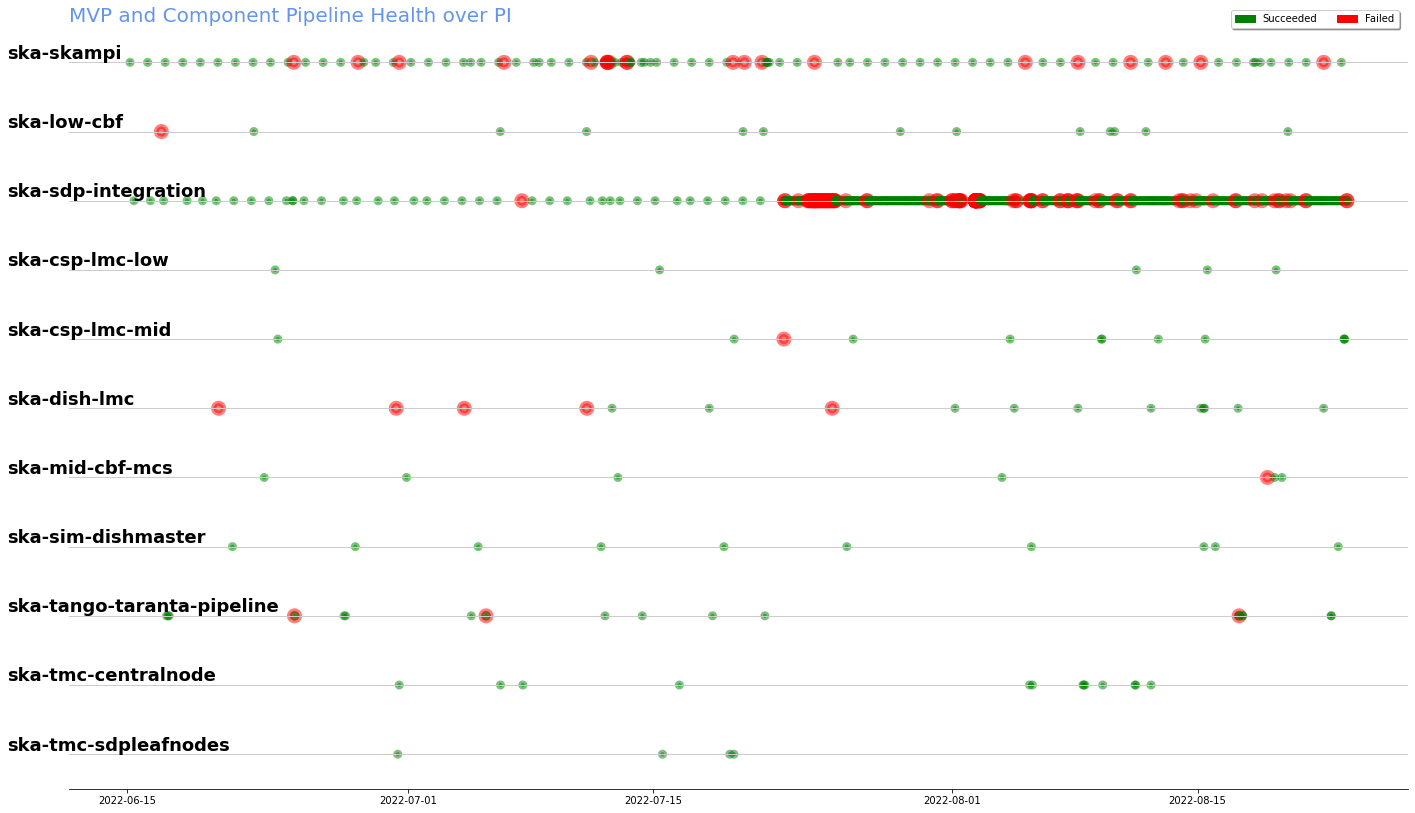

In [75]:
# https://stackoverflow.com/questions/44951911/plot-a-binary-timeline-in-matplotlib

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
plt.title('MVP and Component Pipeline Health over PI', fontsize=20, color='cornflowerblue', loc='left')
ax.yaxis.set_visible(False)
ax.get_yaxis().set_ticklabels([])

handles = []
handle = mpatches.Patch(color='green', label='Succeeded')
handles.append(handle)
handle = mpatches.Patch(color='red', label='Failed')
handles.append(handle)
    
ax.legend(
    handles=handles, 
    ncol=len(handles), loc='upper center', bbox_to_anchor=(0.93, 1.03),
          fancybox=True, shadow=True)

#Stile ticks
# fig.autofmt_xdate()


cnt = 0
for proj in projects:
    data = df_mvp_pipelines[df_mvp_pipelines.project == proj]
    cnt = cnt + 1
    pos = cnt*2
    ax.scatter(
        data['time'].tolist(),
        [pos] * data.shape[0],
        c=data['colour'].tolist(),
        s=data['size'].tolist(),
        marker='o',
        linewidth=5,
        alpha=.5)
    
    ax.axhline(
        pos, 
        linewidth=1,
        c='#CCCCCC')
    
    min_date = df_mvp_pipelines['time'].min()
    days = timedelta(days=7)
    ax.annotate(
        proj.split('/')[-1], 
        (min_date - days, pos),
        fontsize=18, annotation_clip=False, verticalalignment='bottom', fontweight='bold')
    
fig.set_size_inches(24, 14)
# ax.get_yaxis().set_visible(False)
# ax.axis('off')
fig
#Hide spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


In [50]:

query_api = client.query_api()
df_pipelines_all = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> drop(columns:["_measurement", "_start", "_stop", "table", "result", "index"])
        |> group()""".format(current_pi))

df_pipelines_all["project_id"] = pd.to_numeric(df_pipelines_all["project_id"])
df_pipelines_all = df_pipelines_all[df_pipelines_all.project_id.isin(project_ids)].reset_index()
# df_pipelines_all[df_pipelines_all.project == "ska-telescope/ska-skampi"]
df_pipelines_all['project'] = df_pipelines_all['project'].str[14:]
df_pipelines_all


index   result  table                            _time  _value  \
0         0  _result      0 2022-06-24 13:12:15.794000+00:00    0.00   
1         1  _result      0 2022-06-24 13:38:27.262000+00:00   40.53   
2         2  _result      0 2022-06-27 08:57:21.511000+00:00   40.53   
3         4  _result      0 2022-07-18 08:48:43.984000+00:00   40.50   
4        21  _result      0 2022-07-22 10:24:36.388000+00:00    0.00   
...     ...      ...    ...                              ...     ...   
9580  35880  _result      0 2022-08-08 14:03:28.681000+00:00   65.00   
9581  35881  _result      0 2022-08-09 14:25:00.299000+00:00   86.00   
9582  35882  _result      0 2022-08-18 07:22:42.609000+00:00    6.00   
9583  35883  _result      0 2022-08-18 13:55:39.581000+00:00    6.00   
9584  36156  _result      0 2022-06-22 19:48:08.676000+00:00  218.00   

            _field       created_by passed pipeline_id  \
0         coverage      Ajaykumar-D  False   572253789   
1         coverage      Ajaykumar-D  False   572257563   
2         coverage      Ajaykumar-D  False   573636983   
3         coverage      Ajaykumar-D  False   590165102   
4         coverage  ElisabettaGiani  False   594243103   
...            ...              ...    ...         ...   
9580  test_success   shraddhabajare   True   607376206   
9581  test_success   shraddhabajare   True   608403828   
9582  test_success   shraddhabajare   True   616386723   
9583  test_success   shraddhabajare   True   616409840   
9584  test_success      taylorhuang   True   570586635   

                                                project  project_id     ref  \
0     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
1     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
2     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
3     ska-tango-taranta-group/ska-tango-taranta-pipe...    32606296    main   
4                                       ska-csp-lmc-mid    25578388  master   
...                                                 ...         ...     ...   
9580                        ska-tmc/ska-tmc-centralnode    23023505  master   
9581                        ska-tmc/ska-tmc-centralnode    23023505  master   
9582                                         ska-skampi    11448712  master   
9583                                         ska-skampi    11448712  master   
9584                                    ska-mid-cbf-mcs    12488466    main   

       status  
0      failed  
1     success  
2     success  
3     success  
4      failed  
...       ...  
9580  success  
9581  success  
9582  success  
9583  success  
9584  success  

[9585 rows x 13 columns]

In [60]:
import numpy as np
pass_rate_table = pd.pivot_table(df_pipelines_all[df_pipelines_all.status == "success"], values='_value', index=['project', '_time'],
                    columns=['_field'], aggfunc=np.sum)
pass_rate_table

_field                                                         coverage  \
project                      _time                                        
low-cbf/ska-low-cbf          2022-06-22 05:38:41.692000+00:00       0.0   
                             2022-07-06 06:36:22.050000+00:00       0.0   
                             2022-07-11 04:33:33.990000+00:00       0.0   
                             2022-07-20 02:32:13.521000+00:00       0.0   
                             2022-07-21 06:24:28.552000+00:00       0.0   
...                                                                 ...   
ska-tmc/ska-tmc-centralnode  2022-08-12 08:24:55.713000+00:00       0.0   
ska-tmc/ska-tmc-sdpleafnodes 2022-06-30 10:27:09.276000+00:00       0.0   
                             2022-07-15 12:26:56.119000+00:00       0.0   
                             2022-07-19 08:26:58.457000+00:00       0.0   
                             2022-07-19 14:07:52.916000+00:00       0.0   

_field                                                         duration  \
project                      _time                                        
low-cbf/ska-low-cbf          2022-06-22 05:38:41.692000+00:00    3409.0   
                             2022-07-06 06:36:22.050000+00:00    3234.0   
                             2022-07-11 04:33:33.990000+00:00    1840.0   
                             2022-07-20 02:32:13.521000+00:00    2109.0   
                             2022-07-21 06:24:28.552000+00:00    1715.0   
...                                                                 ...   
ska-tmc/ska-tmc-centralnode  2022-08-12 08:24:55.713000+00:00     885.0   
ska-tmc/ska-tmc-sdpleafnodes 2022-06-30 10:27:09.276000+00:00     972.0   
                             2022-07-15 12:26:56.119000+00:00     918.0   
                             2022-07-19 08:26:58.457000+00:00     899.0   
                             2022-07-19 14:07:52.916000+00:00     950.0   

_field                                                             last_run  \
project                      _time                                            
low-cbf/ska-low-cbf          2022-06-22 05:38:41.692000+00:00  1.655876e+09   
                             2022-07-06 06:36:22.050000+00:00  1.657089e+09   
                             2022-07-11 04:33:33.990000+00:00  1.657514e+09   
                             2022-07-20 02:32:13.521000+00:00  1.658284e+09   
                             2022-07-21 06:24:28.552000+00:00  1.658385e+09   
...                                                                     ...   
ska-tmc/ska-tmc-centralnode  2022-08-12 08:24:55.713000+00:00  1.660293e+09   
ska-tmc/ska-tmc-sdpleafnodes 2022-06-30 10:27:09.276000+00:00  1.656585e+09   
                             2022-07-15 12:26:56.119000+00:00  1.657888e+09   
                             2022-07-19 08:26:58.457000+00:00  1.658219e+09   
                             2022-07-19 14:07:52.916000+00:00  1.658240e+09   

_field                                                         pass_rate  \
project                      _time                                         
low-cbf/ska-low-cbf          2022-06-22 05:38:41.692000+00:00  100.00000   
                             2022-07-06 06:36:22.050000+00:00  100.00000   
                             2022-07-11 04:33:33.990000+00:00  100.00000   
                             2022-07-20 02:32:13.521000+00:00  100.00000   
                             2022-07-21 06:24:28.552000+00:00  100.00000   
...                                                                  ...   
ska-tmc/ska-tmc-centralnode  2022-08-12 08:24:55.713000+00:00  111.22449   
ska-tmc/ska-tmc-sdpleafnodes 2022-06-30 10:27:09.276000+00:00  100.00000   
                             2022-07-15 12:26:56.119000+00:00  100.00000   
                             2022-07-19 08:26:58.457000+00:00  100.00000   
                             2022-07-19 14:07:52.916000+00:00  100.00000   

_field                         

In [61]:
df_test_results = df_pipelines_all[["_time", "_field", "_value", "status", "project"]].reset_index()
df_test_results = df_test_results.rename(columns={"_time": "time", "_value": "value", "_field": "field"})
df_test_results.sort_values(by=['project', 'time', 'field'], ascending=[True, True, True], inplace=True)
# df_test_results['colour'] = df_test_results['status'].apply(lambda x: 'green' if x == 'success' else 'red')
# df_test_results['size'] = df_test_results['status'].apply(lambda x: 4 ** 2 if x == 'success' else 10 ** 2)
df_test_results

index                             time         field         value  \
879     879 2022-06-16 23:10:50.078000+00:00      coverage  0.000000e+00   
1944   1944 2022-06-16 23:10:50.078000+00:00      duration  1.810000e+02   
3009   3009 2022-06-16 23:10:50.078000+00:00      last_run  1.655421e+09   
4074   4074 2022-06-16 23:10:50.078000+00:00     pass_rate  0.000000e+00   
5139   5139 2022-06-16 23:10:50.078000+00:00    test_count  0.000000e+00   
...     ...                              ...           ...           ...   
4329   4329 2022-07-19 14:07:52.916000+00:00    test_count  6.300000e+01   
5394   5394 2022-07-19 14:07:52.916000+00:00    test_error  0.000000e+00   
6459   6459 2022-07-19 14:07:52.916000+00:00   test_failed  0.000000e+00   
7524   7524 2022-07-19 14:07:52.916000+00:00  test_skipped  0.000000e+00   
8589   8589 2022-07-19 14:07:52.916000+00:00  test_success  6.300000e+01   

       status                       project  
879    failed           low-cbf/ska-low-cbf  
1944   failed           low-cbf/ska-low-cbf  
3009   failed           low-cbf/ska-low-cbf  
4074   failed           low-cbf/ska-low-cbf  
5139   failed           low-cbf/ska-low-cbf  
...       ...                           ...  
4329  success  ska-tmc/ska-tmc-sdpleafnodes  
5394  success  ska-tmc/ska-tmc-sdpleafnodes  
6459  success  ska-tmc/ska-tmc-sdpleafnodes  
7524  success  ska-tmc/ska-tmc-sdpleafnodes  
8589  success  ska-tmc/ska-tmc-sdpleafnodes  

[9585 rows x 6 columns]

In [53]:
projects = df_test_results['project'].unique()
projects = list(reversed(["ska-skampi"] + sorted(list(filter(lambda x: not x == "ska-skampi", projects)))))
projects

['ska-tmc/ska-tmc-sdpleafnodes',
 'ska-tmc/ska-tmc-centralnode',
 'ska-tango-taranta-group/ska-tango-taranta-pipeline',
 'ska-sim-dishmaster',
 'ska-mid-cbf-mcs',
 'ska-dish-lmc',
 'ska-csp-lmc-mid',
 'ska-csp-lmc-low',
 'sdp/ska-sdp-integration',
 'low-cbf/ska-low-cbf',
 'ska-skampi']

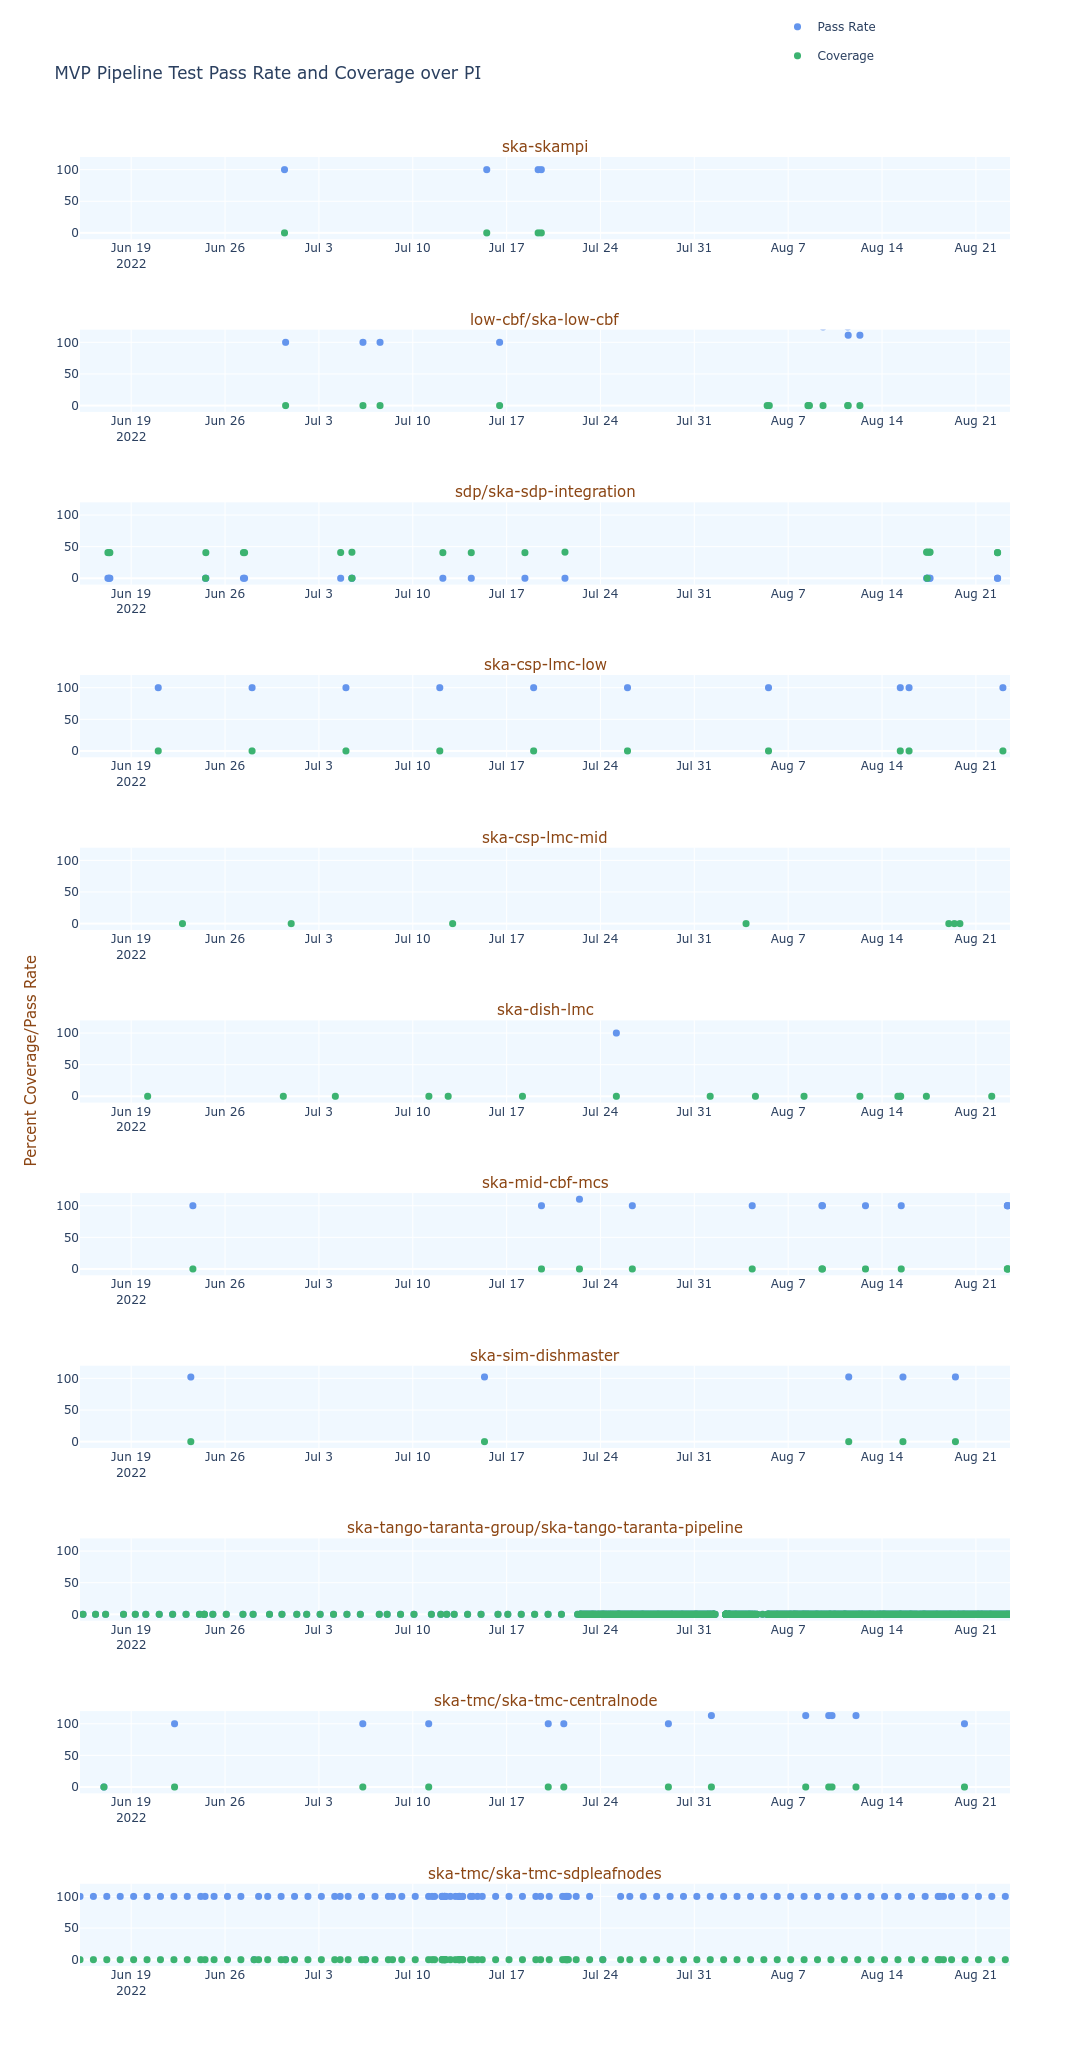

In [59]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=len(projects), 
                    cols=1, 
                    vertical_spacing = 0.05, 
                    subplot_titles = list(reversed(projects)),
                    y_title='Percent Coverage/Pass Rate',)

cnt = 0
yesno = True
for proj in projects:
    data_pass_rate = df_test_results[(df_test_results.project == proj) & (df_test_results.field == 'pass_rate')]
    data_coverage = df_test_results[(df_test_results.project == proj) & (df_test_results.field == 'coverage')]
    cnt = cnt + 1
    # pos = cnt*2
    fig.append_trace(go.Scatter(
        x=data_pass_rate.time, y=data_pass_rate.value, mode='markers', marker=dict(size=7), line=dict(color='cornflowerblue', width=1),
     name="Pass Rate", showlegend=yesno,legendgroup="group1"), row=cnt, col=1)
    fig.append_trace(go.Scatter(
        x=data_coverage.time, y=data_coverage.value, mode='markers', marker=dict(size=7), line=dict(color='mediumseagreen', width=1),
     name="Coverage", showlegend=yesno, legendgroup="group2"), row=cnt, col=1)
    fig.update_xaxes(range=[df_test_results.time.min(), df_test_results.time.max()], row=cnt, col=1)
    fig.update_yaxes(range=[-10, 110], row=cnt, col=1)
    yesno = False

fig.update_layout(height=2046, width=1024,
                  title_text="MVP Pipeline Test Pass Rate and Coverage over PI",
                  plot_bgcolor='aliceblue',
                  showlegend=True, legend=dict(
                                            yanchor="top",
                                            y=1.08,
                                            xanchor="left",
                                            x=0.75
                                        ))
fig.update_annotations(font=dict(size=15, color="saddlebrown"))
fig.show()
    

In [55]:
df =  df_pipelines_all[(df_pipelines_all.project == "ska-skampi") & (df_pipelines_all.status == "success")]
df = df[["_time", "_field", "_value", "status", "project"]].reset_index()
df = df.rename(columns={"_time": "time", "_value": "value", "_field": "field"})
df[(df.field != "coverage") & (df.field != "duration") & (df.field != "last_run")]

index                             time         field  value   status  \
237   3200 2022-07-12 08:17:07.146000+00:00     pass_rate  100.0  success   
238   3202 2022-07-12 19:28:22.827000+00:00     pass_rate  100.0  success   
239   3231 2022-06-28 12:03:34.372000+00:00     pass_rate  100.0  success   
240   3232 2022-07-14 20:04:25.702000+00:00     pass_rate  100.0  success   
241   3234 2022-07-21 09:11:09.943000+00:00     pass_rate  100.0  success   
..     ...                              ...           ...    ...      ...   
706   9561 2022-08-20 04:44:38.310000+00:00  test_success    6.0  success   
707   9562 2022-08-21 04:33:40.459000+00:00  test_success    6.0  success   
708   9564 2022-08-23 04:42:03.138000+00:00  test_success    6.0  success   
709   9582 2022-08-18 07:22:42.609000+00:00  test_success    6.0  success   
710   9583 2022-08-18 13:55:39.581000+00:00  test_success    6.0  success   

        project  
237  ska-skampi  
238  ska-skampi  
239  ska-skampi  
240  ska-skampi  
241  ska-skampi  
..          ...  
706  ska-skampi  
707  ska-skampi  
708  ska-skampi  
709  ska-skampi  
710  ska-skampi  

[474 rows x 6 columns]

In [56]:
import gitlab
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
#  and r.status == "success"
df_testing = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
        |> drop(columns:["_measurement",  "_time", "_start", "_stop", "passed", "status", "ref",
                         "duration", "last_run", "project", "project_id", "coverage", "test_error", "test_failed"])
        |> group()""".format(current_pi))
df_testing["tests_run"] = df_testing.test_count - df_testing.test_skipped
# df_testing = df_testing[(df_testing.tests_run > 0) & (df_testing.test_success > 0)]
df_testing.pass_rate = df_testing.test_success / df_testing.tests_run
df_testing = df_testing[["created_by", "pipeline_id", "pass_rate", "tests_run", "test_success"]].reset_index()
# df_testing[(df_testing.pass_rate < 1.0)]
df_testing = df_testing[["created_by", "pass_rate", "tests_run", "test_success"]].groupby(['created_by']).agg(['count', 'size', 'nunique', 'sum', 'mean']).reset_index()
df_testing['count'] = df_testing['pass_rate']['count']
df_testing['total_pass_rate'] = df_testing['pass_rate']['sum'].map('{:,.2f}'.format)
df_testing['mean_pass_rate'] = df_testing['pass_rate']['mean'] * 100
df_testing['mean_pass_rate'] = df_testing['mean_pass_rate'].map('{:,.2f} %'.format)
df_testing['total_tests_run'] = df_testing['tests_run']['sum'].map('{:,.0f}'.format)
df_testing['total_test_success'] = df_testing['test_success']['sum']
df_testing = df_testing[["created_by", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run", "total_test_success"]]
df_testing.sort_values(by=['count'], ascending=[False], inplace=True)
df_topN = df_testing.head(10).reset_index()
gl = gitlab.Gitlab()
names = []
for index, row in df_topN.iterrows():
    user = gl.users.list(username=str(row["created_by"].iloc[0]).strip())
    names.append(user[0].name)
df_topN["Author"] = names
        
df_topN = df_topN[["Author", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run"]].rename(columns={"count": "Test runs", "total_pass_rate": "Pass Rate(Sum)", "mean_pass_rate": "Pass Rate(Mean)", "total_tests_run": "Total Tests"})
df_topN.style.hide_index()\
    .set_properties(subset=['Author'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('Top 10 Testers')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])


In [57]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
#  and r.status == "success"
df_testing = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: {0[start]}, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines")
        |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
        |> drop(columns:["_measurement",  "_time", "_start", "_stop", "passed", "status", "ref",
                         "duration", "last_run", "coverage", "test_error", "test_failed"])
        |> group()""".format(current_pi))
df_testing["tests_run"] = df_testing.test_count - df_testing.test_skipped
# df_testing = df_testing[(df_testing.tests_run > 0) & (df_testing.test_success > 0)]
df_testing.pass_rate = df_testing.test_success / df_testing.tests_run
df_testing = df_testing[["project", "project_id", "pass_rate", "tests_run", "test_success"]].reset_index()
# df_testing[(df_testing.pass_rate < 1.0)]
df_testing = df_testing[["project", "pass_rate", "tests_run", "test_success"]].groupby(['project']).agg(['count', 'size', 'nunique', 'sum', 'mean']).reset_index()
df_testing['count'] = df_testing['pass_rate']['count']
df_testing['total_pass_rate'] = df_testing['pass_rate']['sum'].map('{:,.2f}'.format)
df_testing['mean_pass_rate'] = df_testing['pass_rate']['mean'] * 100
df_testing['mean_pass_rate'] = df_testing['mean_pass_rate'].map('{:,.2f} %'.format)
df_testing['total_tests_run'] = df_testing['tests_run']['sum'].map('{:,.0f}'.format)
df_testing['total_test_success'] = df_testing['test_success']['sum']
df_testing = df_testing[["project", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run", "total_test_success"]]
df_testing.sort_values(by=['count'], ascending=[False], inplace=True)
df_topN = df_testing.head(10).reset_index()
df_topN = df_topN[["project", "count", "total_pass_rate", "mean_pass_rate", "total_tests_run"]].rename(columns={"count": "Test runs", "project": "Project", "total_pass_rate": "Pass Rate(Sum)", "mean_pass_rate": "Pass Rate(Mean)", "total_tests_run": "Total Tests"})
df_topN.style.hide_index()\
    .set_properties(subset=['Project'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('Top 10 Project Testers')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])
